# <b>Introduction<b>

In this project, I classify Yelp round-10 review datasets. The reviews contain a lot of metadata that can be mined and used to infer meaning, business attributes, and sentiment. For simplicity, I classify the review comments into two class: either as positive or negative. Reviews that have star higher than three are regarded as positive while the reviews with star less than or equal to 3 are negative. Therefore, the problem is a supervised learning. To build and train the model, I first tokenize the text and convert them to sequences. Each review comment is limited to 50 words. As a result, short texts less than 50 words are padded with zeros, and long ones are truncated. After processing the review comments, I trained three model in three different ways: 

<li> Model-1: In this model, a neural network with LSTM and a single embedding layer were used. 
<li> Model-2: In Model-1, an extra 1D convolutional layer has been added on top of LSTM layer to reduce the training time.
<li> Model-3:  In this model, I use the same network architecture as Model-2, but use the pre-trained glove 100 dimension word embeddings as initial input.

Since there are about 1.6 million input comments, it takes a while to train the models. To reduce the training time step, I limit the training epoch to three. After three epochs, it is evident that Model-2 is better regarding both training time and validation accuracy.

## <b>Project Outline <b>

In this project I will cover the follwouings :

<li> Download data from yelp and process them
<li> Build neural network with LSTM
<li> Build neural network with LSTM and CNN
<li> Use pre-trained GloVe word embeddings
<li> Word Embeddings from Word2Vec

# Configuration

In [1]:
# Parameters
PROJECT_NAME = 'ML1010_Weekly'
ENABLE_COLAB = False

#Root Machine Learning Directory. Projects appear underneath
GOOGLE_DRIVE_MOUNT = '/content/gdrive' 
COLAB_ROOT_DIR = GOOGLE_DRIVE_MOUNT + '/MyDrive/Colab Notebooks'
COLAB_INIT_DIR = COLAB_ROOT_DIR + '/utility_files'

LOCAL_ROOT_DIR = '/home/magni//ML_Root/project_root'
LOCAL_INIT_DIR = LOCAL_ROOT_DIR + '/utility_files'

# Bootstrap Environment

In [2]:
#add in support for utility file directory and importing
import sys
import os

if ENABLE_COLAB:
  #Need access to drive
  from google.colab import drive
  drive.mount(GOOGLE_DRIVE_MOUNT, force_remount=True)
  
  #add in utility directory to syspath to import 
  INIT_DIR = COLAB_INIT_DIR
  sys.path.append(os.path.abspath(INIT_DIR))
  
  #Config environment variables
  ROOT_DIR = COLAB_ROOT_DIR
  
else:
  #add in utility directory to syspath to import
  INIT_DIR = LOCAL_INIT_DIR
  sys.path.append(os.path.abspath(INIT_DIR))
  
  #Config environment variables
  ROOT_DIR = LOCAL_ROOT_DIR

#Import Utility Support
from jarvis import Jarvis
jarvis = Jarvis(ROOT_DIR, PROJECT_NAME)

import mv_python_utils as mvutils

Wha...where am I?
I am awake now.

I have set your current working directory to /home/magni/ML_Root/project_root/ML1010_Weekly
The current time is 17:10
Hello sir. Reminder, no more coffee.



# Setup Runtime Environment

In [3]:
if ENABLE_COLAB:
  #!pip install scipy -q
  #!pip install scikit-learn -q
  #!pip install pycaret -q
  #!pip install matplotlib -q
  #!pip install joblib -q
  #!pip install pandasql -q

  display('Google Colab enabled')
else:
  display('Google Colab not enabled')

#Common imports
import json
import gzip
import pandas as pd
import numpy as np
import matplotlib
import re
import nltk
import matplotlib.pyplot as plt

pd.set_option('mode.chained_assignment', None)
nltk.download('stopwords')
%matplotlib inline

'Google Colab not enabled'

[nltk_data] Downloading package stopwords to /home/magni/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## <b>Import libraries<b>

In [4]:
# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation
from keras.layers.embeddings import Embedding

## Plot
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
import matplotlib as plt

# NLTK
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

# Other
import re
import string
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE

2022-01-11 17:10:15.894812: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-11 17:10:15.894838: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## <b> Data Processing<b>

In [5]:
df = pd.read_csv(jarvis.DATA_DIR + '/sentiment_analysis/yelp_labelled.txt',
                 sep = '\t',
                 names = ['text', 'stars'])

In [6]:
df.head(2)

,text,stars
0,Wow... Loved this place.,1
1,Crust is not good.,0


In [7]:
df= df.dropna()
df = df[df.stars.apply(lambda x: str(x).isnumeric())]
df = df[df.stars.apply(lambda x: x !="")]
df = df[df.text.apply(lambda x: x !="")]

In [8]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1000 non-null   object
 1   stars   1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 23.4+ KB


,stars
count,1000.00000
mean,0.50000
std,0.50025
min,0.00000
25%,0.00000
50%,0.50000
75%,1.00000
max,1.00000


In [9]:
df.head()

,text,stars
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


### Convert five classes into two classes (positive = 1 and negative = 0)

Since the main purpose is to identify positive or negative comments, I convert five class star category into two classes: 

<li> (1) Positive: comments with stars > 3 and 
<li> (2) Negative: comments with stars <= 3

In [10]:
labels = df['stars'].map(lambda x : 1 if int(x) > 3 else 0)

### Tokenize text data

Because of the computational expenses, I use the top 20000 unique words. First, tokenize the comments then convert those into sequences. I keep 50 words to limit the number of words in each comment. 

In [11]:
def clean_text(text):
    
    ## Remove puncuation
    text = text.translate(string.punctuation)
    
    ## Convert words to lower case and split them
    text = text.lower().split()
    
    ## Remove stop words
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops and len(w) >= 3]
    
    text = " ".join(text)

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    
    text = text.split()
    stemmer = SnowballStemmer('english')
    stemmed_words = [stemmer.stem(word) for word in text]
    text = " ".join(stemmed_words)

    return text

In [12]:
df['text'] = df['text'].map(lambda x: clean_text(x))

In [13]:
df.head(10)

,text,stars
0,wow love place,1
1,crust good,0
2,tasti textur nasti,0
3,stop late may bank holiday rick steve recommen...,1
4,select menu great price,1
5,get angri want damn pho,0
6,honeslti tast fresh,0
7,potato like rubber could tell made ahead time ...,0
8,fri great too,1
9,great touch,1


In [14]:
vocabulary_size = 20000
tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(df['text'])

sequences = tokenizer.texts_to_sequences(df['text'])
data = pad_sequences(sequences, maxlen=50)

In [15]:
print(data.shape)

(1000, 50)


###  <b>Build neural network with LSTM<b>

### Network Architechture

The network starts with an embedding layer. The layer lets the system expand each token to a more massive vector, allowing the network to represent a word in a meaningful way. The layer takes 20000 as the first argument, which is the size of our vocabulary, and 100 as the second input parameter, which is the dimension of the embeddings. The third parameter is the input_length of 50, which is the length of each comment sequence.

In [16]:
model_lstm = Sequential()
model_lstm.add(Embedding(20000, 100, input_length=50))
model_lstm.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model_lstm.add(Dense(1, activation='sigmoid'))
model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

2022-01-11 17:10:17.286554: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-01-11 17:10:17.286596: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-01-11 17:10:17.286614: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (localhost.localdomain): /proc/driver/nvidia/version does not exist
2022-01-11 17:10:17.286889: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Train the network

There are about 1.6 million comments, and it takes a while to train the model in a MacBook Pro. To save time I have used only three epochs. GPU machines can be used to accelerate the training with more time steps. I split the whole datasets as 60% for training and 40% for validation.

In [17]:
model_lstm.fit(data, np.array(labels), validation_split=0.4, epochs=3)

Epoch 1/3
19/19 [==============================] - 3s 62ms/step - loss: 0.3047 - accuracy: 0.9550 - val_loss: 0.0027 - val_accuracy: 1.0000
Epoch 2/3
19/19 [==============================] - 1s 51ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 3.4373e-04 - val_accuracy: 1.0000
Epoch 3/3
19/19 [==============================] - 1s 53ms/step - loss: 2.5323e-04 - accuracy: 1.0000 - val_loss: 1.7430e-04 - val_accuracy: 1.0000


##  <b>Build neural network with LSTM and CNN <b>
The LSTM model worked well. However, it takes forever to train three epochs. One way to speed up the training time is to improve the network adding “Convolutional” layer. Convolutional Neural Networks (CNN) come from image processing. They pass a “filter” over the data and calculate a higher-level representation. They have been shown to work surprisingly well for text, even though they have none of the sequence processing ability of LSTMs.

In [18]:
def create_conv_model():
    model_conv = Sequential()
    model_conv.add(Embedding(vocabulary_size, 100, input_length=50))
    model_conv.add(Dropout(0.2))
    model_conv.add(Conv1D(64, 5, activation='relu'))
    model_conv.add(MaxPooling1D(pool_size=4))
    model_conv.add(LSTM(100))
    model_conv.add(Dense(1, activation='sigmoid'))
    model_conv.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model_conv 

In [19]:
model_conv = create_conv_model()
model_conv.fit(data, np.array(labels), validation_split=0.4, epochs = 3)

Epoch 1/3
19/19 [==============================] - 2s 39ms/step - loss: 0.2534 - accuracy: 0.9467 - val_loss: 4.0228e-04 - val_accuracy: 1.0000
Epoch 2/3
19/19 [==============================] - 0s 22ms/step - loss: 1.2631e-04 - accuracy: 1.0000 - val_loss: 4.5305e-05 - val_accuracy: 1.0000
Epoch 3/3
19/19 [==============================] - 0s 22ms/step - loss: 3.5124e-05 - accuracy: 1.0000 - val_loss: 3.0010e-05 - val_accuracy: 1.0000


### Save processed Data

In [20]:
df_save = pd.DataFrame(data)
df_label = pd.DataFrame(np.array(labels))

In [21]:
result = pd.concat([df_save, df_label], axis = 1)

In [22]:
result.to_csv(jarvis.ROOT_DIR + '/train_dense_word_vectors.csv', index=False)

## <b>Use pre-trained Glove word embeddings<b>

In this subsection, I want to use word embeddings from pre-trained Glove. It was trained on a dataset of one billion tokens (words) with a vocabulary of 400 thousand words. The glove has embedding vector sizes, including 50, 100, 200 and 300 dimensions. I chose the 100-dimensional version. I also want to see the model behavior in case the learned word weights do not get updated. I, therefore, set the trainable attribute for the model to be False.

### Get embeddings from Glove 

In [23]:
embeddings_index = dict()
f = open('/home/magni/ML_Root/glove_encodings/glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [24]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocabulary_size, 100))
for word, index in tokenizer.word_index.items():
    if index > vocabulary_size - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

### Develop model

I use the same model architecture with a convolutional layer on top of the LSTM layer. 

In [25]:
model_glove = Sequential()
model_glove.add(Embedding(vocabulary_size, 100, input_length=50, weights=[embedding_matrix], trainable=False))
model_glove.add(Dropout(0.2))
model_glove.add(Conv1D(64, 5, activation='relu'))
model_glove.add(MaxPooling1D(pool_size=4))
model_glove.add(LSTM(100))
model_glove.add(Dense(1, activation='sigmoid'))
model_glove.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [26]:
model_glove.fit(data, np.array(labels), validation_split=0.4, epochs = 3)

Epoch 1/3
19/19 [==============================] - 2s 33ms/step - loss: 0.2932 - accuracy: 0.9717 - val_loss: 0.0117 - val_accuracy: 1.0000
Epoch 2/3
19/19 [==============================] - 0s 15ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 1.9117e-05 - val_accuracy: 1.0000
Epoch 3/3
19/19 [==============================] - 0s 14ms/step - loss: 1.4756e-05 - accuracy: 1.0000 - val_loss: 1.2453e-05 - val_accuracy: 1.0000


## <b>Word embedding visialization<b>

In this subsection, I want to visualize word embedding weights obtained from trained models. Word embeddings with 100 dimensions are first reduced to 2 dimensions using t-SNE. Tensorflow has an excellent tool to visualize the embeddings in a great way, but here I just want to visualize the word relationship. 

### Get embedding weights from glove

In [27]:
lstm_embds = model_lstm.layers[0].get_weights()[0]

In [28]:
conv_embds = model_conv.layers[0].get_weights()[0]

In [29]:
glove_emds = model_glove.layers[0].get_weights()[0]

### Get word list 

In [30]:
word_list = []
for word, i in tokenizer.word_index.items():
    word_list.append(word)

### Scatter plot of first two components of TSNE

In [31]:
def plot_words(data, start, stop, step):
    trace = go.Scatter(
        x = data[start:stop:step,0], 
        y = data[start:stop:step, 1],
        mode = 'markers',
        text= word_list[start:stop:step]
    )
    layout = dict(title= 't-SNE 1 vs t-SNE 2',
                  yaxis = dict(title='t-SNE 2'),
                  xaxis = dict(title='t-SNE 1'),
                  hovermode= 'closest')
    fig = dict(data = [trace], layout= layout)
    py.iplot(fig)

#### 1. LSTM

In [56]:
number_of_words = 2000
lstm_tsne_embds = TSNE(n_components=2).fit_transform(lstm_embds)

/home/magni/python_env/ML1010_env2/lib64/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/home/magni/python_env/ML1010_env2/lib64/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



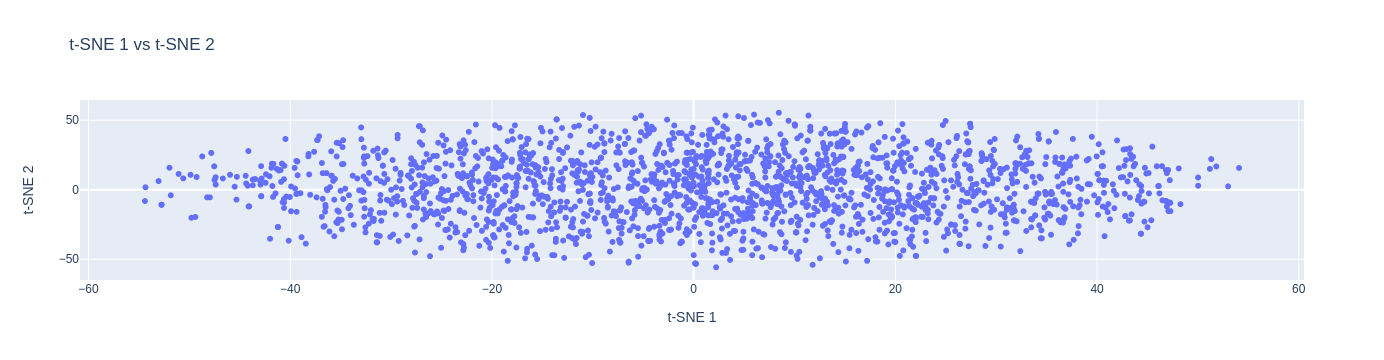

In [57]:
plot_words(lstm_tsne_embds, 0, number_of_words, 1)

#### 2. CNN + LSTM

In [58]:
conv_tsne_embds = TSNE(n_components=2).fit_transform(conv_embds)

/home/magni/python_env/ML1010_env2/lib64/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/home/magni/python_env/ML1010_env2/lib64/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



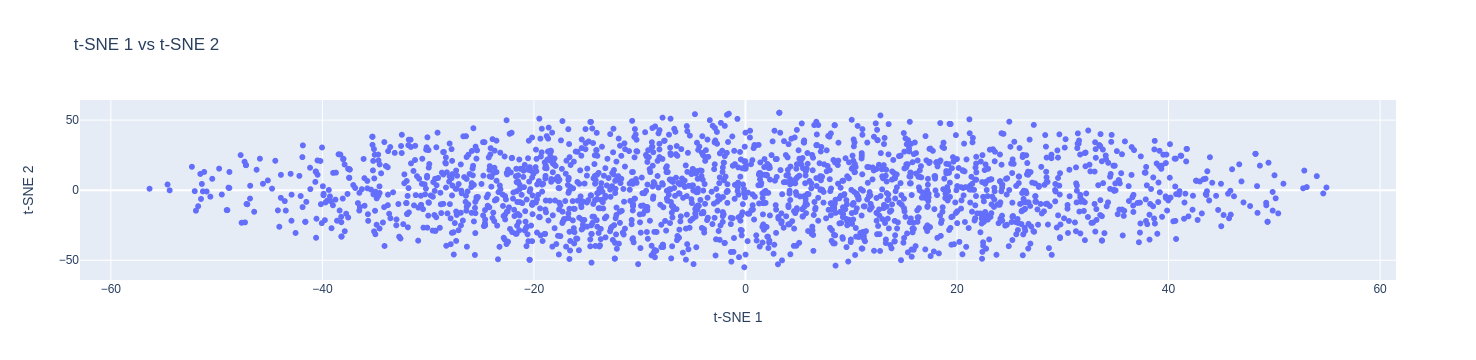

In [59]:
plot_words(conv_tsne_embds, 0, number_of_words, 1)

#### 3. Glove 

In [61]:
glove_tsne_embds = TSNE(n_components=2).fit_transform(glove_emds)

/home/magni/python_env/ML1010_env2/lib64/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/home/magni/python_env/ML1010_env2/lib64/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



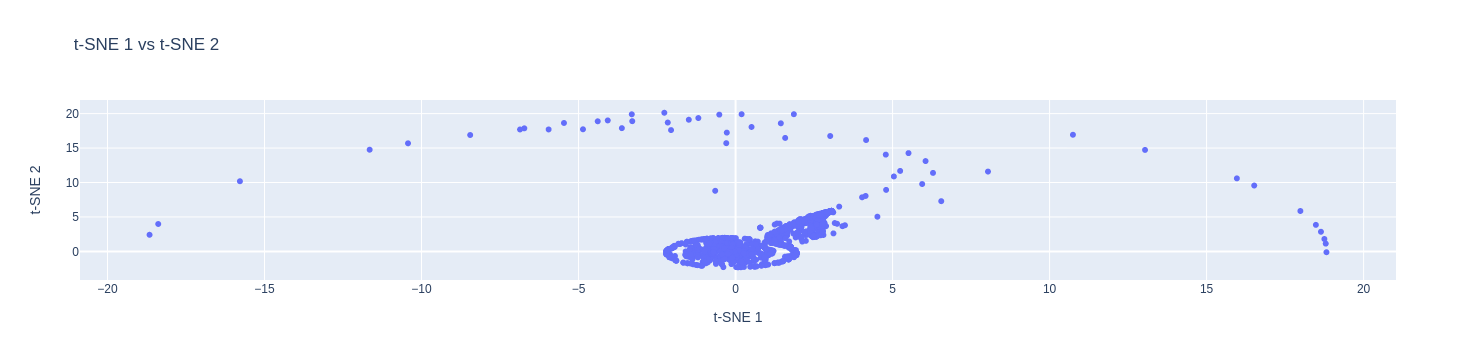

In [62]:
plot_words(glove_tsne_embds, 0, number_of_words, 1)

## <b>Word Embeddings from Word2Vec<b>

In this subsection, I use word2vec to create word embeddings from the review comments. Word2vec is one algorithm for learning a word embedding from a text corpus.

In [63]:
from gensim.models import Word2Vec
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/magni/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

###  Tokenize the reviews coments. 

In [64]:
df['tokenized'] = df.apply(lambda row : nltk.word_tokenize(row['text']), axis=1)

In [65]:
df.head()

,text,stars,tokenized
0,wow love place,1,"[wow, love, place]"
1,crust good,0,"[crust, good]"
2,tasti textur nasti,0,"[tasti, textur, nasti]"
3,stop late may bank holiday rick steve recommen...,1,"[stop, late, may, bank, holiday, rick, steve, ..."
4,select menu great price,1,"[select, menu, great, price]"


### Train word2vec model

In [82]:
model_w2v = Word2Vec(df['tokenized'], vector_size=100)

In [89]:
for index, word in enumerate(model_w2v.wv.index_to_key):
    if index == 10:
        break
    print(f"word #{index}/{len(model_w2v.wv.index_to_key)} is {word}")

word #0/294 is !
word #1/294 is food
word #2/294 is place
word #3/294 is good
word #4/294 is servic
word #5/294 is great
word #6/294 is back
word #7/294 is time
word #8/294 is i
word #9/294 is like


In [115]:
print (len(model_w2v.wv))
print(model_w2v)
type(model_w2v)

294
Word2Vec(vocab=294, vector_size=100, alpha=0.025)


gensim.models.word2vec.Word2Vec

In [131]:
#Original for use in Gensim < 4.0
#X = model_w2v[model_w2v.wv.vocab]

#Attempts at understanding upgrade
#X = model_w2v.wv.index_to_key
#X = np.array(model_w2v.wv.index_to_key).reshape(1, -1)
#X = model_w2v.wv
#X = model_w2v.wv.key_to_index
X = np.array(model_w2v.wv.key_to_index)
#X = model_w2v.wv.index_to_key.keys()
#X = model_w2v.wv.get_normed_vectors()

In [144]:
from sklearn.manifold import TSNE
import textscatter

XY = TSNE(model_w2v)
#figure 
textscatter(XY,words)
title("Word Embedding t-SNE Plot")

ModuleNotFoundError: No module named 'textscatter'

In [135]:
#print (model_w2v.wv.get_vecattr(model_w2v.wv.index_to_key))
print (model_w2v.wv.index_to_key)

TypeError: get_vecattr() missing 1 required positional argument: 'attr'

### Plot Word Vectors Using PCA

In [85]:
from sklearn.decomposition import TruncatedSVD

In [132]:
tsvd = TruncatedSVD(n_components=5, n_iter=10)
result = tsvd.fit_transform(X)

TypeError: float() argument must be a string or a number, not 'dict'

In [112]:
result.shape

(294, 5)

In [114]:
tsvd_word_list = []
words = list(model_w2v.wv)
for i, word in enumerate(words):
    tsvd_word_list.append(word)

trace = go.Scatter(
    x = result[0:number_of_words, 0], 
    y = result[0:number_of_words, 1],
    mode = 'markers',
    text= tsvd_word_list[0:number_of_words]
)

layout = dict(title= 'SVD 1 vs SVD 2',
              yaxis = dict(title='SVD 2'),
              xaxis = dict(title='SVD 1'),
              hovermode= 'closest')

fig = dict(data = [trace], layout= layout)
py.iplot(fig)

KeyError: "Key '294' not present"

In [146]:


def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

tsne_plot(model_w2v)



AttributeError: The vocab attribute was removed from KeyedVector in Gensim 4.0.0.
Use KeyedVector's .key_to_index dict, .index_to_key list, and methods .get_vecattr(key, attr) and .set_vecattr(key, attr, new_val) instead.
See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4